In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import seaborn as sns

import xgboost as xgb
from xgboost import plot_importance, plot_tree
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from tqdm import tqdm
from itertools import product

In [2]:
from codecarbon import EmissionsTracker

codecarbon_output = "./codecarbon_emissions.csv"

In [3]:
df = pd.read_csv('./final-data-pre-processed.csv', sep=',')
df

,DATA,HORA,"PRECIPITAÇÃO TOTAL, HORÁRIO (mm)","PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)",PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB),PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB),RADIACAO GLOBAL (KJ/m²),"TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)",TEMPERATURA DO PONTO DE ORVALHO (°C),TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C),TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C),UMIDADE REL. MAX. NA HORA ANT. (AUT) (%),UMIDADE REL. MIN. NA HORA ANT. (AUT) (%),"UMIDADE RELATIVA DO AR, HORARIA (%)","VENTO, DIREÇÃO HORARIA (gr) (° (gr))","VENTO, RAJADA MAXIMA (m/s)","VENTO, VELOCIDADE HORARIA (m/s)",timestamp
0,2007-05-18,18:00:00,0.0,1010.0,1010.1,1010.0,100.8,23.5,21.1,23.8,23.5,21.2,21.1,87.0,85.0,86.0,224.0,6.4,4.6,2007-05-18 18:00:00
1,2007-05-18,19:00:00,0.0,1010.4,1010.4,1010.3,35.6,23.2,21.0,23.3,23.2,21.1,20.7,88.0,86.0,87.0,234.0,7.9,5.5,2007-05-18 19:00:00
2,2007-05-19,11:00:00,0.0,1013.2,1013.2,1013.1,91.2,23.6,19.3,23.6,23.1,19.3,18.2,77.0,74.0,77.0,37.0,2.0,0.4,2007-05-19 11:00:00
3,2007-05-19,12:00:00,0.0,1013.5,1013.5,1013.2,141.0,23.9,20.6,23.9,23.6,20.6,19.4,82.0,77.0,82.0,104.0,1.5,0.9,2007-05-19 12:00:00
4,2007-05-19,13:00:00,0.0,1013.8,1013.9,1013.8,428.8,25.0,19.3,25.0,24.3,19.5,19.0,74.0,71.0,71.0,239.0,5.4,3.9,2007-05-19 13:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145134,2024-02-16,14:00:00,0.0,1010.5,1010.6,1010.4,2954.0,26.4,23.3,26.8,26.2,23.5,23.0,84.0,81.0,83.0,265.0,10.5,4.2,2024-02-16 14:00:00
145135,2024-02-16,15:00:00,0.0,1010.1,1010.6,1010.0,2329.2,26.5,23.2,26.5,25.4,23.5,22.5,86.0,82.0,82.0,268.0,11.7,4.3,2024-02-16 15:00:00
145136,2024-02-16,16:00:00,0.0,1009.7,1010.1,1009.7,2605.8,26.3,23.3,27.0,25.9,23.7,22.8,84.0,79.0,83.0,261.0,10.3,4.6,2024-02-16 16:00:00
145137,2024-02-16,17:00:00,0.0,1009.6,1009.7,1009.5,1389.0,25.6,23.2,26.5,25.5,23.5,22.9,87.0,83.0,87.0,263.0,10.3,4.0,2024-02-16 17:00:00


## X, y

In [26]:
X_prec = df[[
       'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)',
       'PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)',
       'PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)',
       'RADIACAO GLOBAL (KJ/m²)',
       'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)',
       'TEMPERATURA DO PONTO DE ORVALHO (°C)',
       'TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)',
       'TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)',
       'TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C)',
       'TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C)',
       'UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)',
       'UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)',
       'UMIDADE RELATIVA DO AR, HORARIA (%)',
       'VENTO, DIREÇÃO HORARIA (gr) (° (gr))', 
       'VENTO, RAJADA MAXIMA (m/s)',
       'VENTO, VELOCIDADE HORARIA (m/s)'
    ]]

y_prec = df['PRECIPITAÇÃO TOTAL, HORÁRIO (mm)']

In [27]:
X_temp = df[[
       'PRECIPITAÇÃO TOTAL, HORÁRIO (mm)',
       'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)',
       'PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)',
       'PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)',
       'RADIACAO GLOBAL (KJ/m²)',
       'UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)',
       'UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)',
       'UMIDADE RELATIVA DO AR, HORARIA (%)',
       'VENTO, DIREÇÃO HORARIA (gr) (° (gr))', 
       'VENTO, RAJADA MAXIMA (m/s)',
       'VENTO, VELOCIDADE HORARIA (m/s)'
    ]]

y_temp = df['TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)']

## functions

In [50]:
def split_train_test(X, y, train_size):
    X_train, X_test = X[:round(X.shape[0]*train_size)], X[round(X.shape[0]*train_size):]
    y_train, y_test = y[:round(y.shape[0]*train_size)], y[round(y.shape[0]*train_size):]

    return X_train, X_test, y_train, y_test

def train_xgboost(X_train, y_train, X_test, y_test, params):
    xgb_model = xgb.train(params, xgb.DMatrix(X_train, label=y_train), num_boost_round=100)
    
    predictions = xgb_model.predict(xgb.DMatrix(X_test))
    
    rmse = mean_squared_error(y_test, predictions)
    
    return xgb_model, predictions
    
def grid_search_xgboost(X_train, y_train, X_test, y_test):
    param_grid = {
        'max_depth': [4, 6, 8],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'min_child_weight': [1, 3, 5]
    }
    
    param_combinations = list(product(
        param_grid['max_depth'],
        param_grid['learning_rate'],
        param_grid['subsample'],
        param_grid['colsample_bytree'],
        param_grid['min_child_weight']
    ))
    
    best_rmse = float('inf')
    best_params = None

    for combination in tqdm(param_combinations, desc="Grid Search Progress"):
        max_depth, learning_rate, subsample, colsample_bytree, min_child_weight = combination
        params = {
            'max_depth': max_depth,
            'eta': learning_rate,
            'subsample': subsample,
            'colsample_bytree': colsample_bytree,
            'min_child_weight': min_child_weight,
            'objective': 'reg:squarederror',
            'eval_metric': 'rmse'
        }
        
        model, predictions = train_xgboost(X_train, y_train, X_test, y_test, params)
        rmse = mean_squared_error(y_test, predictions)
        
        if rmse < best_rmse:
            best_rmse = rmse
            best_params = params
    
    print("Best parameters found:")
    print(best_params)
    print(f"Best RMSE: {best_rmse}")
    
    final_model, final_predictions = train_xgboost(X_train, y_train, X_test, y_test, best_params)
    
    return final_model, final_predictions, best_params

def evaluate_model(y_test, prediction):
  print(f"MAE: {mean_absolute_error(y_test, prediction)}")
  print(f"MSE: {mean_squared_error(y_test, prediction)}")
  print(f"MRSE: {np.sqrt(mean_squared_error(y_test, prediction))}")

def plot_real_vs_predicted(y_test, predictions, save=False):
    plt.figure(figsize=(8, 8))
    plt.scatter(y_test, predictions, alpha=0.7, color='blue')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red', linewidth=2, label="Ideal Fit")
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title("Real vs Predicted Values")
    plt.legend()
    plt.grid(True)

    if save: 
        plt.savefig(save)
    
    plt.show()

def plot_prediction_over_time(y_test, predictions, timestamps, start_date=None, end_date=None, save=False):
    timestamps = pd.to_datetime(timestamps)

    data = pd.DataFrame({
        'Timestamp': timestamps,
        'Actual': y_test,
        'Predicted': predictions
    })

    if start_date:
        data = data[data['Timestamp'] >= pd.to_datetime(start_date)]
    if end_date:
        data = data[data['Timestamp'] <= pd.to_datetime(end_date)]

    plt.figure(figsize=(12, 6))
    plt.plot(data['Timestamp'], data['Actual'], label='Actual Values', color='blue', linewidth=2)
    plt.plot(data['Timestamp'], data['Predicted'], label='Predicted Values', color='orange', linewidth=2)
    plt.xlabel('Time')
    plt.ylabel('Values')
    plt.title('Actual vs. Predicted Values Over Time')
    plt.legend()
    plt.grid(True)

    
    if save: 
        plt.savefig(save)
        
    plt.show()

In [32]:
timestamps_test = df.iloc[round(df.shape[0] * 0.8):]["timestamp"]

## xbg precipitation

In [55]:
X_train, X_test, y_train, y_test = split_train_test(X_prec, y_prec, 0.8)

tracker = EmissionsTracker(
    project_name="xgboost precipiptation train 0.8",
    output_file='./codecarbon_emissions.csv',
    log_level = "critical"
)

tracker.start()

prec_model, prec_predictions, prec_best_params = grid_search_xgboost(X_train, y_train, X_test, y_test)

emissions: float = tracker.stop()
print(f"emissions={emissions}")

Grid Search Progress: 100%|██████████████████████████| 243/243 [01:39<00:00,  2.43it/s]


Best parameters found:
{'max_depth': 8, 'eta': 0.01, 'subsample': 0.6, 'colsample_bytree': 1.0, 'min_child_weight': 5, 'objective': 'reg:squarederror', 'eval_metric': 'rmse'}
Best RMSE: 1.2122000782448084
emissions=4.59762132203653e-05


In [56]:
evaluate_model(y_test, prec_predictions)

MAE: 0.2225495112588891
MSE: 1.2122000782448084
MRSE: 1.1009995814008324


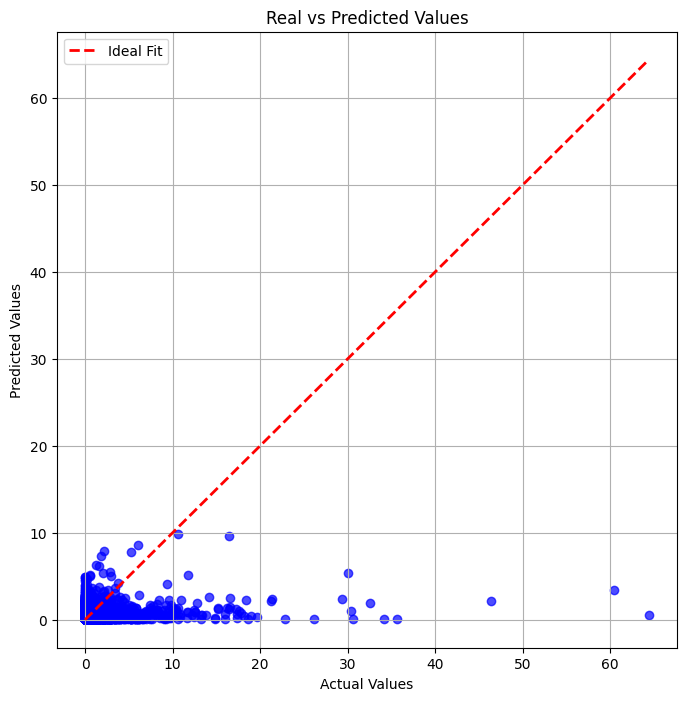

In [57]:
plot_real_vs_predicted(y_test, prec_predictions, save='./images/models/xgb_prec_real_x_pred.png')

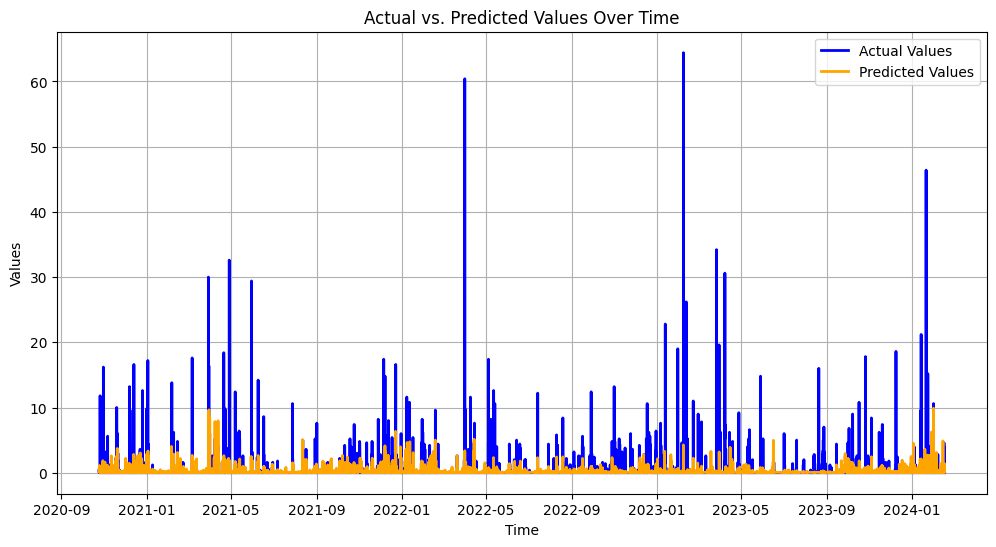

In [35]:
plot_prediction_over_time(y_test, prec_predictions, timestamps_test)

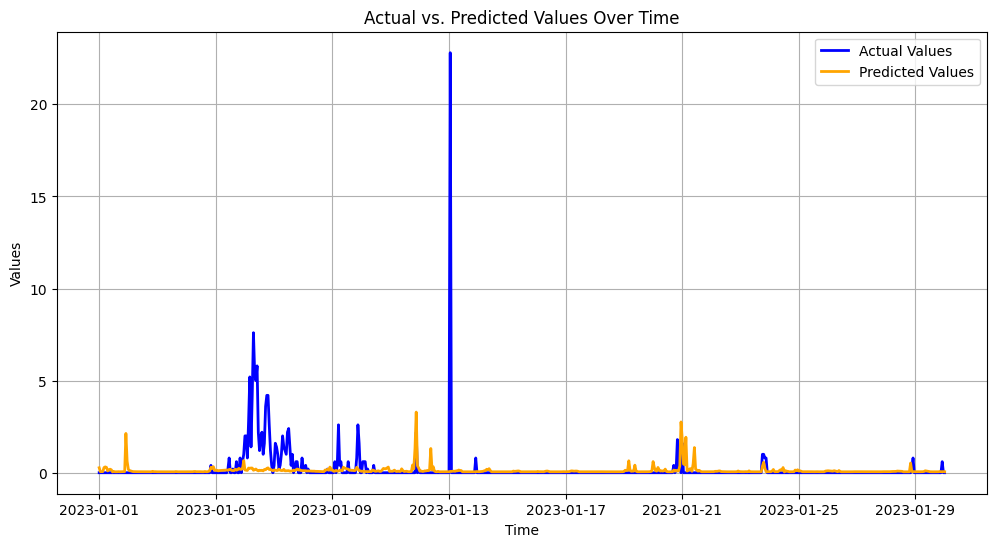

In [61]:
start_date = "2023-01-01"
end_date = "2023-01-30"

plot_prediction_over_time(y_test, prec_predictions, timestamps_test, start_date, end_date, save='./images/models/xgb_prec_pred.png')

## xgb temperature

In [45]:
X_train, X_test, y_train, y_test = split_train_test(X_temp, y_temp, 0.8)

tracker = EmissionsTracker(
    project_name="xgboost temperature train 0.8",
    output_file='./codecarbon_emissions.csv',
    log_level = "critical"
)

tracker.start()

temp_model, temp_predictions, temp_best_params = grid_search_xgboost(X_train, y_train, X_test, y_test)

emissions: float = tracker.stop()
print(f"emissions={emissions}")

Grid Search Progress: 100%|██████████████████████████| 243/243 [01:34<00:00,  2.57it/s]


Best parameters found:
{'max_depth': 6, 'eta': 0.1, 'subsample': 0.6, 'colsample_bytree': 0.6, 'min_child_weight': 3, 'objective': 'reg:squarederror', 'eval_metric': 'rmse'}
Best RMSE: 3.249795466724105
emissions=4.3342735543343585e-05


In [46]:
evaluate_model(y_test, temp_predictions)

MAE: 1.401884701870617
MSE: 3.249795466724105
MRSE: 1.8027189095153202


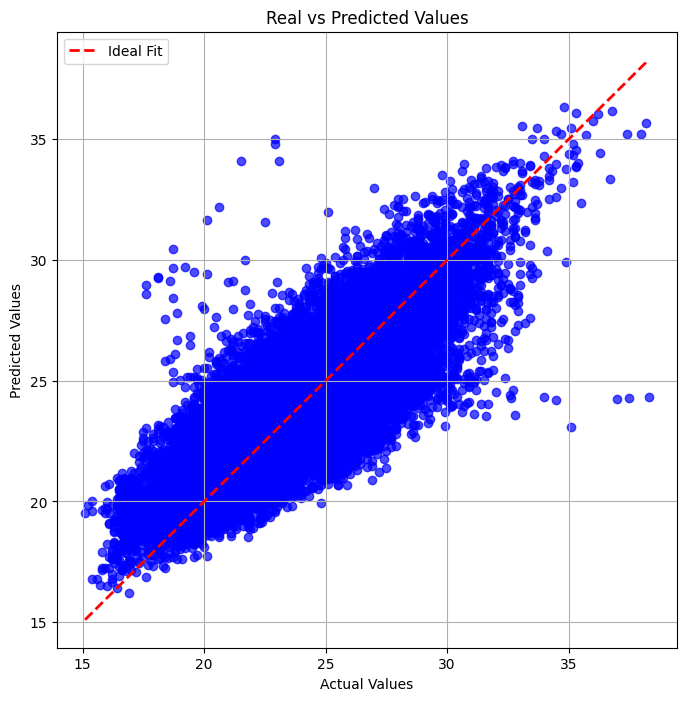

In [51]:
plot_real_vs_predicted(y_test, temp_predictions, save='./images/models/xgb_temp_real_x_pred.png')

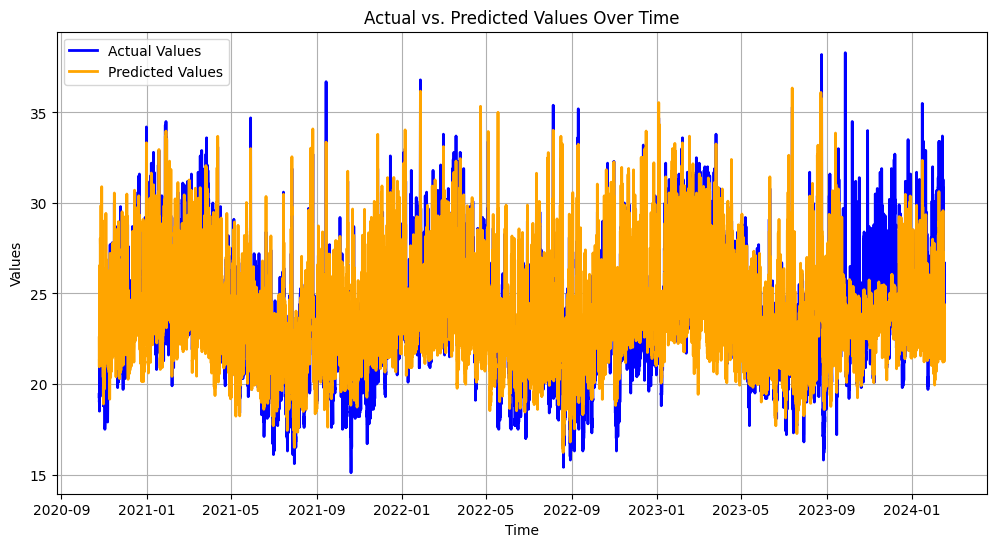

In [48]:
plot_prediction_over_time(y_test, temp_predictions, timestamps_test)

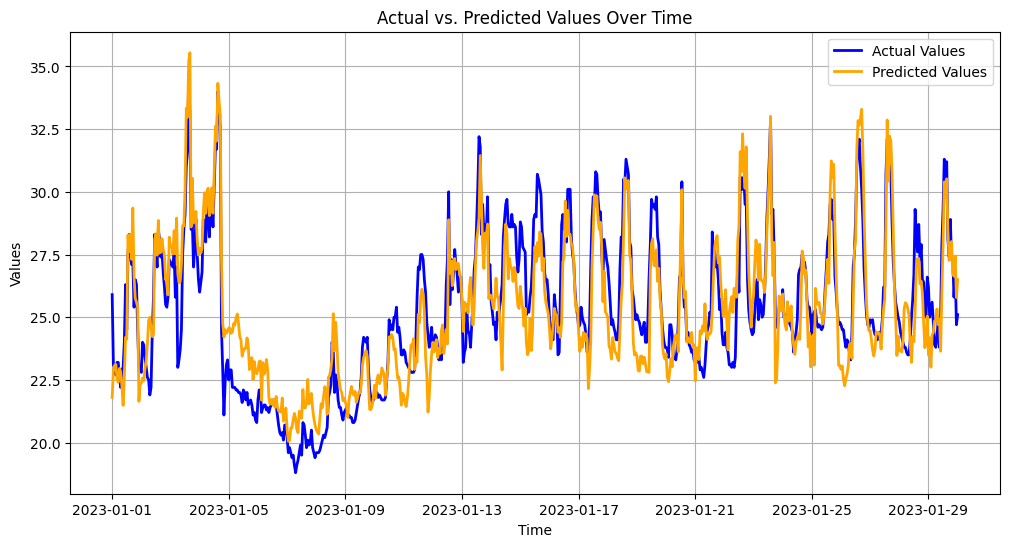

In [52]:
start_date = "2023-01-01"
end_date = "2023-01-30"

plot_prediction_over_time(y_test, temp_predictions, timestamps_test, start_date, end_date, save='./images/models/xgb_pred_temp.png')